Chapter 2 EX Walkthrough

In [7]:
import os
from six.moves import urllib
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, LabelEncoder,OneHotEncoder,LabelBinarizer, StandardScaler, minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV,RandomizedSearchCV
import warnings
# import sklearn-pandas
from sklearn.compose import ColumnTransformer
warnings.filterwarnings("ignore")

Get the Data from the Web

In [8]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    return tgz_path

In [9]:
path = fetch_housing_data()

Load the Extracted CSV file and explore it

In [44]:
housing_csv_path = os.path.join(HOUSING_PATH,"housing.csv")
housing_data = pd.read_csv(housing_csv_path)
housing_data.head()
housing_data.describe() 
print (housing_data.shape)
# housing_data.info() # 7 missing values for total_bedrooms

(20640, 10)


Seperate out targets and features, Explore the Target; far from being normally distributed, a handful of outliers

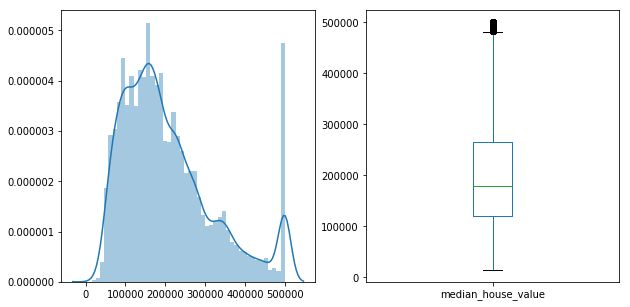

In [11]:
target_col = 'median_house_value'
housing_target = housing_data.loc[:,housing_data.columns == target_col]
housing_features = housing_data.loc[:,housing_data.columns != target_col]
# housing_features.head()

plt.figure(1)
plt.subplot(121)
sns.distplot(housing_target)
plt.subplot(122)
housing_data[target_col].plot.box(figsize = (10,5))
plt.show()

Categorical Features

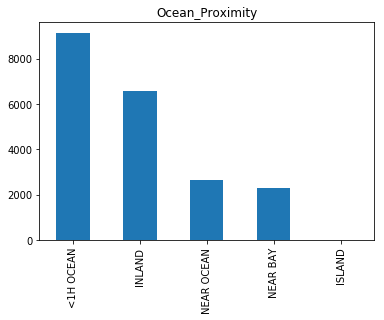

In [12]:
housing_data.ocean_proximity.value_counts().plot.bar(title = 'Ocean_Proximity')

Numerical Features

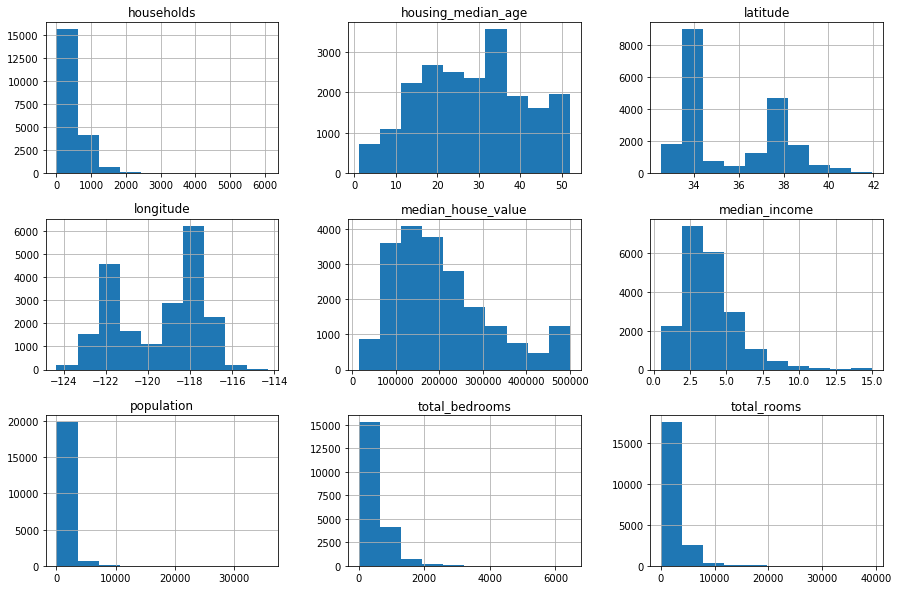

In [13]:
housing_data.hist(figsize = (15,10))
plt.show()

Bivariate Analysis

In [14]:
pd.crosstab(housing_data.median_house_value,housing_data.ocean_proximity)

ocean_proximity,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
median_house_value,,,,,
14999.0,0,4,0,0,0
17500.0,1,0,0,0,0
22500.0,0,2,0,1,1
25000.0,0,1,0,0,0
26600.0,0,1,0,0,0
26900.0,0,1,0,0,0
27500.0,0,1,0,0,0
28300.0,0,0,0,0,1
30000.0,0,2,0,0,0


Numeric --> Categorical Data

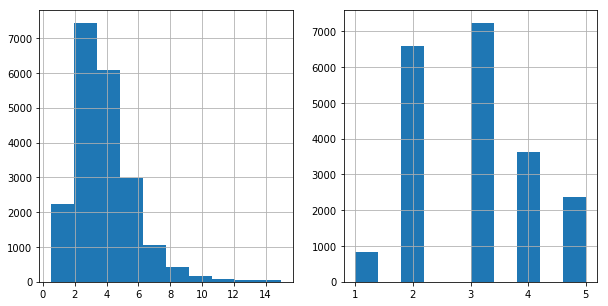

In [15]:
# housing_data['median_income_cat'] = pd.cut(housing_data['median_income'], 5, labels = [1,2,3,4,5])
plt.figure()
plt.subplot(121)
# housing_data['median_income_cat'].value_counts().plot.bar() # Data not distributed well among all 5 categories
housing_data['median_income'].hist(figsize = (10,5))
housing_data['median_income_cat'] = pd.cut(housing_data['median_income'], [0,1.5,3,4.5,6,np.inf], labels = [1,2,3,4,5]) # med_income seems to be mostly around average 
# print(housing_data['median_income_cat'][:20])
# print(housing_data['median_income'][:20])
plt.subplot(122)
housing_data['median_income_cat'].hist() # Data not distributed well among all 5 categories
plt.show()

Set aside a Test Set

In [16]:
# X_train, X_test, Y_train, Y_test = train_test_split(housing_features, housing_target,test_size = 0.2,random_state = 42)

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_ind, test_ind in sss.split(housing_data, housing_data["median_income_cat"]): # Group housing data based on median income
    housing_train = housing_data.loc[train_ind]
    housing_test = housing_data.loc[test_ind]
# housing_train.head()
housing_test.head()
# housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3


In [19]:
# Drop the median_income_cat, which conveys same info as median_income
# for cat_col in (housing_train, housing_test):
#     cat_col.drop("median_income_cat", axis = 1, inplace = True)

housing_test.shape

(4128, 10)

Discover and Visualize Data to gain insights

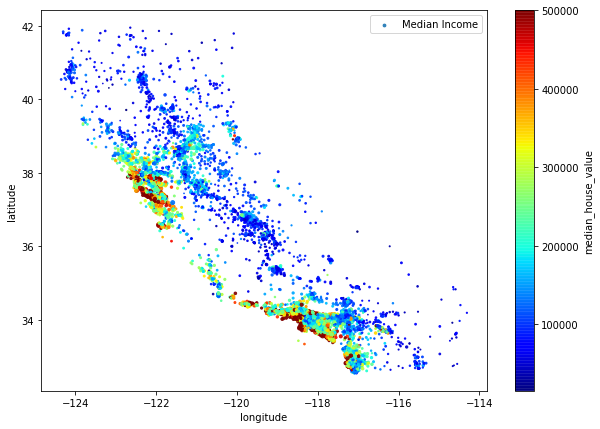

In [20]:
housing_train.plot(kind="scatter", x="longitude", y="latitude",alpha=0.9,
     s= housing_train["median_income"],label = 'Median Income',figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False) # alpha -- RBGA-related, a measure of the amt of transparency
plt.legend() 
# We can also load Cali's map and hold this plot on top of that [src: see AGeron's Github for this]

In [21]:
# Bivariate Corr Analysis
housing_train.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


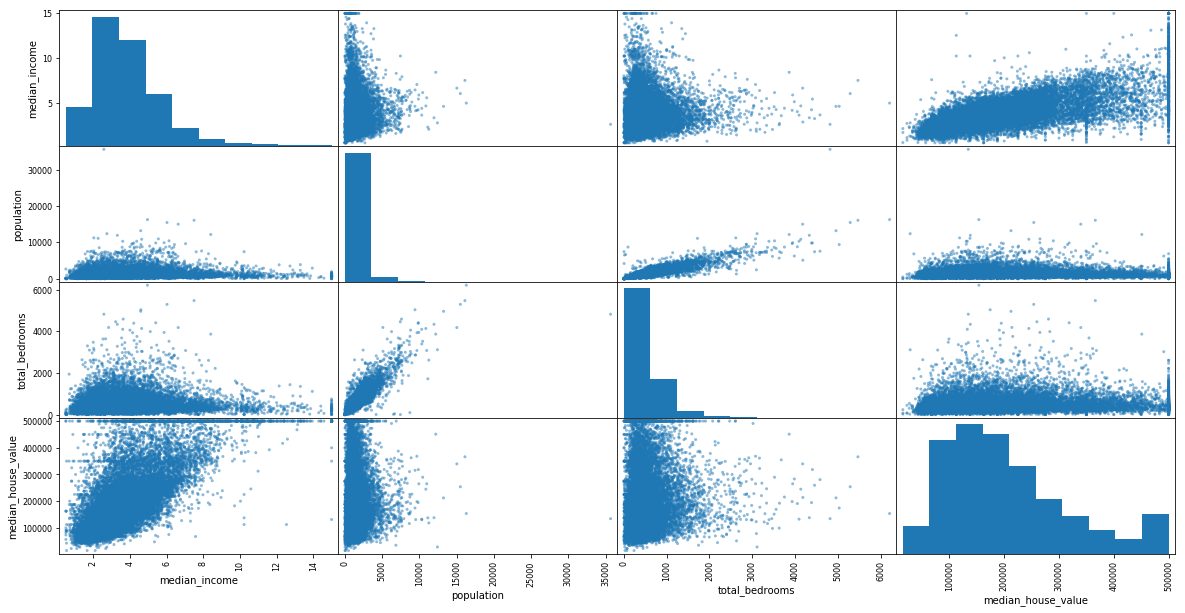

In [22]:
pd.plotting.scatter_matrix(housing_train[['median_income','population','total_bedrooms','median_house_value']],figsize=(20,10))
plt.show()
# =========> - Median House Value highly and positively correlated with median_income!! - Data caps (horizontal lines) are also being observed<==============
# What do population and total_bedrooms have to do w wach other tho?

Prepare the data

In [23]:
""" Training Features and Target Sets """
housing_features_train = housing_train.loc[:, housing_train.columns != target_col]
housing_target_train = housing_train.loc[:,target_col]
# print (housing_features_train.shape)
# print (housing_target_train.shape)
# housing_features_train.head()
""" Missing Values """
# print (np.sum(housing_features_train.isna())) # confirming that total_bedrooms is the attribute with missing values
# housing_total_bedrooms = housing_features_train.total_bedrooms
# total_bedroom_median = housing_total_bedrooms.median()
# housing_total_bedrooms.fillna(total_bedroom_median,inplace = True)
# print (np.sum(housing_features_train.isna()))

' Missing Values '

Pipelining and combining transformed_cat and transformed_num

METHOD 1

In [38]:
numeric_housing = housing_features_train.loc[:, housing_features_train.columns != 'ocean_proximity']
categorical_housing = housing_features_train['ocean_proximity']
lb = LabelBinarizer()
transformed_cat = lb.fit_transform(categorical_housing)
numeric_transformer = Pipeline([('imputer',SimpleImputer(missing_values =np.nan,strategy = 'median')),
                               ('standardscaler',StandardScaler())])
transformed_num = numeric_transformer.fit_transform(numeric_housing)
transformed_features = np.concatenate((transformed_num,transformed_cat),axis = 1)
# print (transformed_features.shape)

(16512, 13)


METHOD 2 - ColumnTransformer

In [25]:
# column_transformer = ColumnTransformer([
#                     ('numeric_transformer',numeric_transformer,numeric_housing),
#                    ('cat_transformer',OneHotEncoder(),categorical_hosuing)])
# # # !!! This kaar nafookooleh! 
# transformed_features = column_transformer.fit_transform(housing_features_train)# ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed
# print (transformed_features.shape) 

METHOD 3 - FeatureUnion

In [26]:
""" Making use of pipelines to automate the preprocessing process"""
# Pipeline imputing missing values, and scaling the numerical features
# numerical_features = housing_features_train.loc[:,housing_features_train.columns != "ocean_proximity"]
# numerical_pipeline = Pipeline([('selector',OldDataFrameSelector(numerical_features)),('imputer',Imputer(strategy = "median")),('stdscaler',StandardScaler())]) # Input Argument: List of (name,transformer) Tuples
# # transformed_num_data = numerical_pipeline.fit_transform(numerical_features.values)
# print(numerical_features.values)
# Pipeline converting cat --> num features
# categorical_features = housing_features_train.ocean_proximity
# categorical_pipeline = Pipeline([('selector',OldDataFrameSelector(categorical_features)),('Binarizer', LabelBinarizer())])
# transformed_cat_data = categorical_pipeline.fit_transform(categorical_features.values)
# Pipeline combining the two aforementioned pipelines
# all_data_pipeline = FeatureUnion([('numerical_pipeline',numerical_pipeline),
#               ('categorical_pipeline',categorical_pipeline)])
# # housing_transformed = all_data_pipeline.fit_transform(housing_features_train.values)
# print (numerical_features.values)


' Making use of pipelines to automate the preprocessing process'

Train the Model

In [27]:
X_train = transformed_features
Y_train = housing_target_train.values


# (Supervised) Training the model on the training set
lr = LinearRegression().fit(X_train,Y_train) 
Y_predicted = lr.predict(X_train)
rmse = np.sqrt(mean_squared_error(Y_train,Y_predicted)) # Error ~ 6e^4 on the training data --> underfitting
print ('Linear Reg Training Err =',rmse)

Linear Reg Training Err = 69050.98178244587


In [28]:
dt = DecisionTreeRegressor().fit(X_train,Y_train)
Y_predicted_dt = dt.predict(X_train)
rmse_dt = np.sqrt(mean_squared_error(Y_train,Y_predicted_dt)) # Model exactly mimicing the trend in train data, hence resulting in rmse = 0.0
print ('Decision Tree Training Err =',rmse_dt)

Decion Tree Training Err = 0.0


In [29]:
rf = RandomForestRegressor().fit(X_train,Y_train)
Y_predicted_rf = rf.predict(X_train)
rmse_rf = np.sqrt(mean_squared_error(Y_train,Y_predicted_rf))
print ('Random Forest Training Err =',rmse_rf)

Random Forest Training Err = 22160.269027311533


In [30]:
svr = SVR(kernel = 'linear').fit(X_train,Y_train)
Y_predicted_svr = rf.predict(X_train)
rmse_svr = np.sqrt(mean_squared_error(Y_train,Y_predicted_svr))
print ('SVR Training Err =',rmse_svr)

SVR Training Err = 22160.269027311533


In [31]:
predictors = {'Linear Reg':lr,'Decision Tree Reg':dt,'Random Forest':rf, 'Support Vector Reg':svr}
for k,v in list(predictors.items()):
    cvs = cross_val_score(v,X_train,Y_train, scoring = 'neg_mean_squared_error',cv = 10,n_jobs=-1) # default is the r2 of the prediction
    print ( k,'Validation Error (+/-) Std = ',np.mean(np.sqrt(-cvs)),'(+/-)',np.std(np.sqrt(-cvs)))

Linear Reg Validation Error (+/-) Std =  69223.18594556303 (+/-) 2657.268311277696
Decision Tree Reg Validation Error (+/-) Std =  69757.08924899253 (+/-) 2498.117703902735
Random Forest Validation Error (+/-) Std =  52148.58009925142 (+/-) 1682.0559536213232
Support Vector Reg Validation Error (+/-) Std =  112431.41324221538 (+/-) 2806.7852183501386


Fine-Tune the Model

METHOD 1 -- GridSearchCV

METHOD 2 -- RandomizedSearchCV

In [33]:
# n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
n_estimators = [3,10,30,500]
# criterion = ["gini","entropy"]
# max_depth = np.linspace(1, 32, 32, endpoint=True)
# min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# max_features = list(range(1,X_train.shape[1]))
max_features = [4,5,9]
# param_dist = {"n_estimators":n_estimators,
#               "max_depth":max_depth,
#              "min_samples_split":min_samples_split,
#               "min_samples_leaf":min_samples_leaf,
#               "max_features":max_features} # dict of name:[ls of val]
param_dist = {"n_estimators":n_estimators,
              "max_features":max_features}
rf = RandomForestRegressor()
rs = RandomizedSearchCV(rf, param_distributions = param_dist, scoring = 'neg_mean_squared_error', cv = 5, refit = True, n_jobs = -1, random_state = 42)
rs.fit(X_train,Y_train)
best_est = rs.best_estimator_
print ('Best estimator = ',best_est)
print ('Best score = ',np.sqrt(-rs.best_score_))
print ('Best params = ',rs.best_params_)
feature_imp = best_est.feature_importances_
print(feature_imp)


Best estimator =  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
Best score =  49353.50636743228
Best params =  {'n_estimators': 500, 'max_features': 9}
[1.12445948e-01 1.02610403e-01 4.96832801e-02 2.86651747e-02
 2.53543040e-02 3.58351767e-02 2.40715820e-02 4.47775235e-01
 9.44525375e-03 1.56675663e-01 6.56567173e-05 1.70390357e-03
 5.66841948e-03]


METHOD 3 -- Combine the best performing models

List the attributes along with their scores

In [35]:
# !!!! X_test as well needs to be transformed and converted to a decent shape 
housing_features_test = housing_test.loc[:,housing_test.columns != 'median_house_value']
housing_target_test = housing_test['median_house_value']

Evaluate the Final Model on the Test Set

In [43]:
num_test = housing_features_test.loc[:, housing_features_test.columns != 'ocean_proximity']
cat_test = housing_features_test['ocean_proximity']
transformed_num = numeric_transformer.transform(num_test)
transformed_cat = lb.transform(cat_test)

transformed_features = np.concatenate((transformed_num,transformed_cat),axis = 1)
X_test = transformed_features
Y_test = housing_target_test.values
Y_pred = best_est.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_pred,Y_test))
print ('Best estimators Err (on the test set) =', rmse)

Best estimators Err (on the test set) = 46372.826470528766


Summary and Result:

1. SVR (with default parameters) --> Overfitting (rmse = 1e^10)
2. Best Estimator/Model = RF (n_est = 500,max_feat = 9 )# what is the def of each? Are we even allowed to set these vals?
3. The most imp factor predicting the housing_prices = median_income